In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from pygadgetreader import readsnap, readheader, readrockstargalaxies

a_list = [0.6, 0.7, 0.8, 0.90, 1.00] 

# Reheating 
#a_reheat = 0.77
a_reheat = 0.8 # (temporary)

# Snapshot files
snapshot_files = {
    0.6: '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.60_eff',
    0.7: '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.70_eff',
    0.8: '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.80_eff',
    0.9: '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.90_eff',
    1.0: '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=1.0_eff',
}

# Rockstar halo catalogs
halo_files = {
    0.6: "/mnt/c/Users/doman/OneDrive/Desktop/rs_dcdm3/0.6/halos_0",
    0.7: "/mnt/c/Users/doman/OneDrive/Desktop/rs_dcdm3/0.7/halos_0",
    0.8: "/mnt/c/Users/doman/OneDrive/Desktop/rs_dcdm3/0.8/halos_0",
    0.9: "/mnt/c/Users/doman/OneDrive/Desktop/rs_dcdm3/0.9/halos_0",
    1.0: "/mnt/c/Users/doman/OneDrive/Desktop/rs_dcdm3/1.00/halos_0",
}

# particle type in GADGET snapshots for DM
DM_PTYPE = "dm"   


In [8]:
def group_halos(particles):
    """
    particles: array from readrockstargalaxies(halo_file, 'particles')
      column 0: particle ID
      column 1: halo ID
    Returns: dict[halo_id] -> np.array(particle_ids)
    """
    pids = particles[:, 0].astype(int)
    hids = particles[:, 1].astype(int)
    unique_halos, cnts = np.unique(hids, return_counts=True)
    split_pids = np.split(pids, np.cumsum(cnts)[:-1])
    return dict(zip(unique_halos, split_pids))


def halo2df(halos, halodict=None):
    """
    halos: structured array from readrockstargalaxies(halo_file, 'halos')
    halodict: optional dict[halo_id] -> particle_ids
    Returns: DataFrame with one row per halo.
    """
    data = {}
    for name in halos.dtype.names:
        arr = halos[name]
        if arr.ndim > 1:
            data[name] = [arr[i] for i in range(len(arr))]
        else:
            data[name] = arr
    df = pd.DataFrame(data)
    if halodict is not None:
        df["pids"] = df["id"].map(halodict)
    return df


def load_rockstar_catalogs(halo_files_dict):
    halos_by_a = {}
    halodict_by_a = {}
    df_by_a = {}
    for a, fname in halo_files_dict.items():
        halos = readrockstargalaxies(fname, "halos")
        particles = readrockstargalaxies(fname, "particles")

        halodict = group_halos(particles)
        df = halo2df(halos, halodict=halodict)

        halos_by_a[a] = halos
        halodict_by_a[a] = halodict
        df_by_a[a] = df

        print(f"a={a}: N_halos={len(df)}")
    return halos_by_a, halodict_by_a, df_by_a


halos_by_a, halodict_by_a, df_by_a = load_rockstar_catalogs(halo_files)

a=0.6: N_halos=192
a=0.7: N_halos=282
a=0.8: N_halos=707
a=0.9: N_halos=814
a=1.0: N_halos=902


In [50]:
def load_snapshot_dm(snapshot_file, ptype=DM_PTYPE):
    """
    Load DM IDs and positions from a GADGET snapshot.
    Returns dict with ids, pos, and id_to_index.
    """
    ids = readsnap(snapshot_file, "pid", ptype)
    pos = readsnap(snapshot_file, "pos", ptype)  # (N,3)
    ids = ids.astype(int)
    id_to_index = {pid: i for i, pid in enumerate(ids)}
    return {"ids": ids, "pos": pos, "id_to_index": id_to_index}


snapshot_dm_by_a = {}
for a in a_list:
    snap = snapshot_files[a]
    #print(f"Loading snapshot a={a} from {snap}")
    snapshot_dm_by_a[a] = load_snapshot_dm(snap)

for a in a_list:
    snap = snapshot_files[a]
    #print(f"Loading velocities for a={a} from {snap}")
    vel = readsnap(snap, "vel", DM_PTYPE)  # pygadgetreader usually returns km/s (physical)
    snapshot_dm_by_a[a]["vel"] = vel

Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Velocities
Returning DM    Velocities
Returning DM    Velocities
Returning DM    Velocities


In [16]:
def build_particle_to_halo_map(halodict):
    """
    halodict: dict[halo_id] -> array of pids
    Returns: dict[pid] -> halo_id
    """
    pid_to_halo = {}
    for hid, pids in halodict.items():
        for pid in pids:
            pid_to_halo[int(pid)] = int(hid)
    return pid_to_halo


pid2halo_by_a = {}
for a in a_list:
    pid2halo_by_a[a] = build_particle_to_halo_map(halodict_by_a[a])
    print(f"a={a}: {len(pid2halo_by_a[a])} particles labeled by Rockstar")

def track_initial_halo_particles(halo_id, a_list, a_start, df_by_a, pid2halo_by_a, snapshot_dm_by_a):
    """
    halo_id: ID of the halo at a_start
    Returns: dict with:
      'halo_id'         : initial halo ID
      'N0'              : initial particle count
      'history'         : list of per-snapshot dicts:
          {
            'a': scale factor,
            'frac_in_any_halo': fraction of original particles in any halo,
            'frac_unbound': fraction in no halo,
            'halo_counts': Counter of host halo IDs,
            'com': center-of-mass position,
            'r_rms': rms radius around COM,
          }
      'particle_ids'    : array of initial member IDs
    """
    df0 = df_by_a[a_start]
    row0 = df0.loc[df0["id"] == halo_id]
    if row0.empty:
        raise ValueError(f"Halo {halo_id} not found at a={a_start}")

    pids0 = row0.iloc[0]["pids"].astype(int)
    N0 = len(pids0)

    history = []

    for a in a_list:
        snap_dm = snapshot_dm_by_a[a]
        pid2halo = pid2halo_by_a[a]

        # host halo for each initial particle (at this snapshot)
        host_ids = [pid2halo.get(pid, None) for pid in pids0]

        # bound vs unbound counts
        n_in_any_halo = sum(hid is not None for hid in host_ids)
        n_unbound = N0 - n_in_any_halo

        frac_in_any = n_in_any_halo / N0
        frac_unbound = n_unbound / N0

        halo_counts = Counter(host_ids)  # includes None key for unbound

        # positions for those particles (at this snapshot)
        id_to_index = snap_dm["id_to_index"]
        pos_all = snap_dm["pos"]

        indices = [id_to_index[pid] for pid in pids0 if pid in id_to_index]
        if len(indices) > 0:
            pos = pos_all[indices]
            com = pos.mean(axis=0)
            r = np.linalg.norm(pos - com, axis=1)
            r_rms = np.sqrt((r**2).mean())
        else:
            com = np.array([np.nan, np.nan, np.nan])
            r_rms = np.nan

        history.append(
            {
                "a": a,
                "frac_in_any_halo": frac_in_any,
                "frac_unbound": frac_unbound,
                "halo_counts": halo_counts,
                "com": com,
                "r_rms": r_rms,
            }
        )

    return {
        "halo_id": halo_id,
        "N0": N0,
        "particle_ids": pids0,
        "history": history,
    }


a=0.6: 13892 particles labeled by Rockstar
a=0.7: 23512 particles labeled by Rockstar
a=0.8: 70410 particles labeled by Rockstar
a=0.9: 82568 particles labeled by Rockstar
a=1.0: 92410 particles labeled by Rockstar


In [ ]:
'''USE ROCKSTAR TO GET THE SELF BOUND CLUMPS BEFORE REHEATING (where we can trust it better)'''

In [ ]:
# pick the starting snapshot just before reheating: a = 0.76 or 0.765

In [17]:
#a_start = 0.765
a_start = 0.7 #(for now)

df_start = df_by_a[a_start].copy()
df_start_sorted = df_start.assign(
        num_p=df_start["pids"].apply(lambda p: len(p))
    ).sort_values("num_p", ascending=False)

TOP_N = 10  # number of big clumps to track by mass
top_halo_ids_start = df_start_sorted.head(TOP_N)["id"].values.astype(int)

top_halo_ids_start

array([ 5,  4, 10, 13, 17,  6, 19,  0,  8,  7])

In [41]:
def compute_initial_com_per_halo(a_start, tracked_halos, snapshot_dm_by_a):
    """
    Compute center-of-mass for each initial halo's particles at a_start.
    Returns: dict[halo_id] -> np.array(3,)
    """
    snap = snapshot_dm_by_a[a_start]
    id_to_index = snap["id_to_index"]
    pos_all = snap["pos"]

    com_per_halo = {}

    for hid, tr in tracked_halos.items():
        pids = tr["particle_ids"]
        indices = [id_to_index[pid] for pid in pids if pid in id_to_index]
        if len(indices) == 0:
            com = np.array([np.nan, np.nan, np.nan])
        else:
            pos = pos_all[indices]
            com = pos.mean(axis=0)
        com_per_halo[hid] = com

    return com_per_halo


COM_per_halo = compute_initial_com_per_halo(a_start, tracked_halos, snapshot_dm_by_a)


In [30]:
# TRACK THE BIGGEST PREHEATING HALOS!
tracked_halos = {}
for hid in top_halo_ids_start:
    #print(f"Tracking initial halo {hid} at a={a_start}")
    tracked_halos[hid] = track_initial_halo_particles(
        halo_id=hid,
        a_list=a_list,
        a_start=a_start,
        df_by_a=df_by_a,
        pid2halo_by_a=pid2halo_by_a,
        snapshot_dm_by_a=snapshot_dm_by_a,)


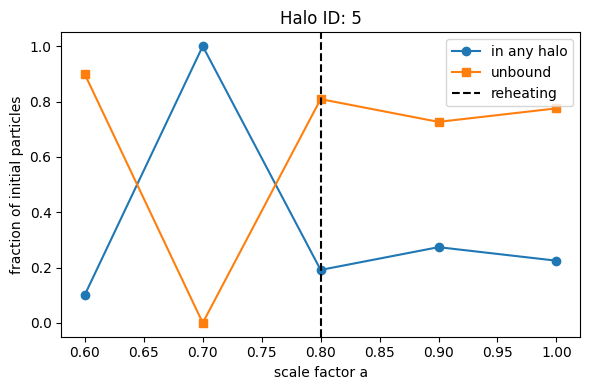

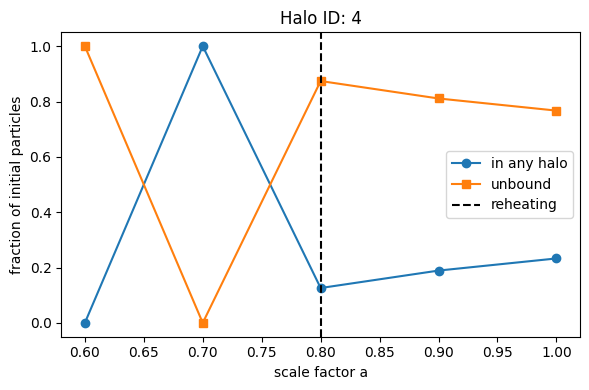

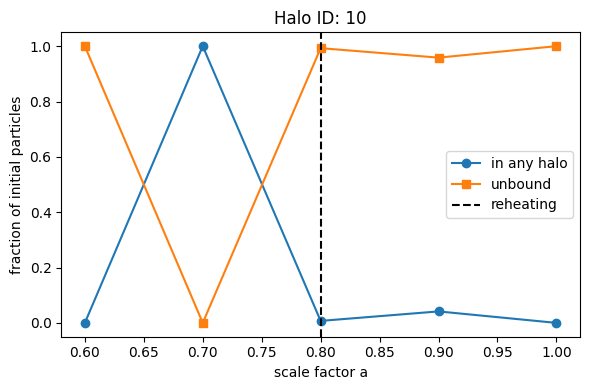

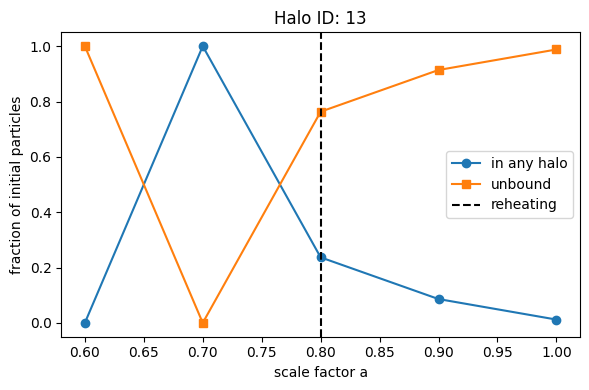

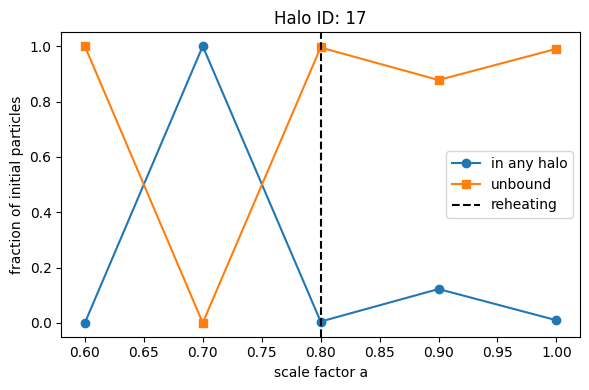

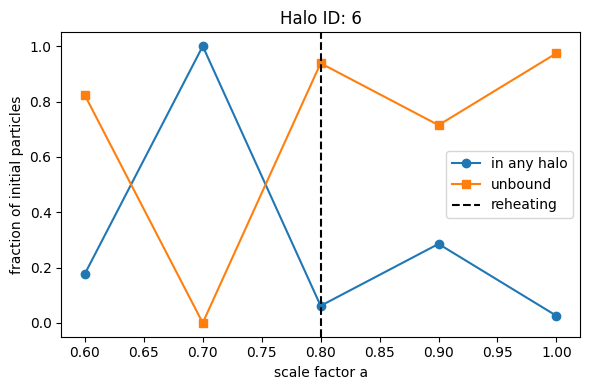

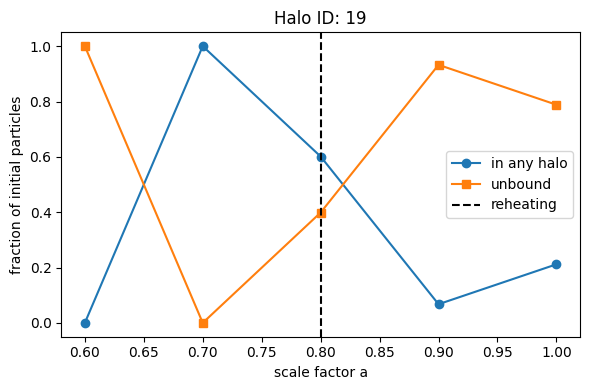

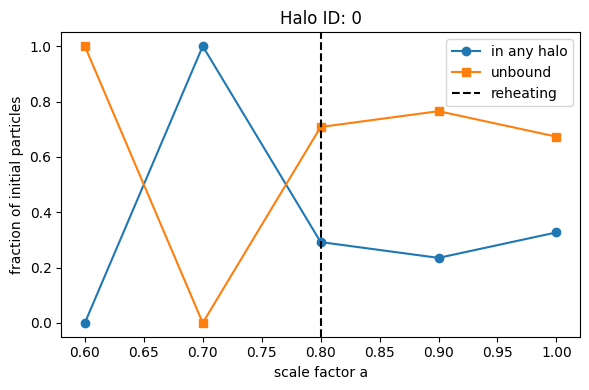

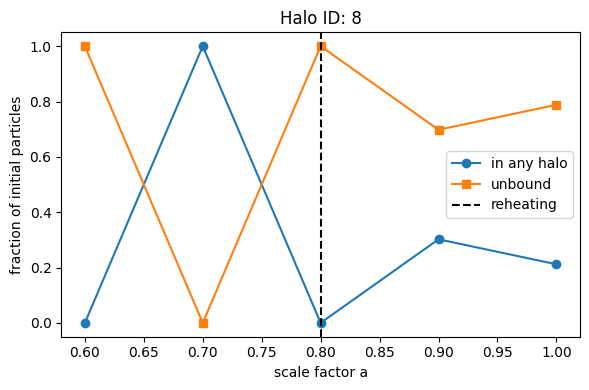

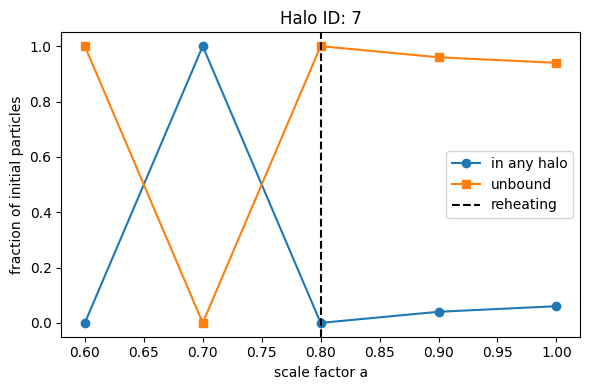

In [35]:
def history_to_df(tracked_entry):
    rows = []
    for h in tracked_entry["history"]:
        rows.append(
            {
                "a": h["a"],
                "frac_in_any_halo": h["frac_in_any_halo"],
                "frac_unbound": h["frac_unbound"],
                "r_rms": h["r_rms"],
            }
        )
    return pd.DataFrame(rows).sort_values("a")


for hid in top_halo_ids_start:
    # Plot for one halo
    hist_df = history_to_df(tracked_halos[hid])
    
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(hist_df["a"], hist_df["frac_in_any_halo"], marker="o", label="in any halo")
    ax1.plot(hist_df["a"], hist_df["frac_unbound"], marker="s", label="unbound")
    ax1.axvline(a_reheat, color="k", linestyle="--", label="reheating")
    ax1.set_xlabel("scale factor a")
    ax1.set_ylabel("fraction of initial particles")
    ax1.legend()
    plt.title(f"Halo ID: {hid}")
    plt.tight_layout()
    plt.show()


In [20]:
# what happens to particles after halos disappears? free streaming?

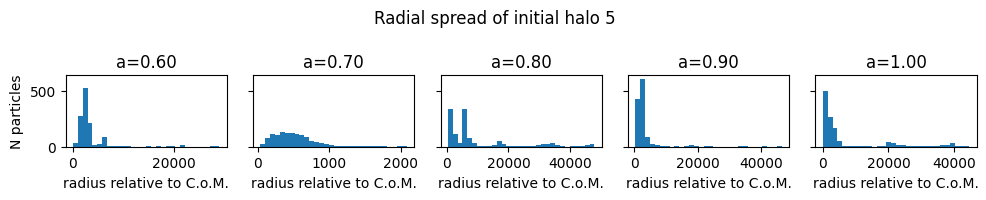

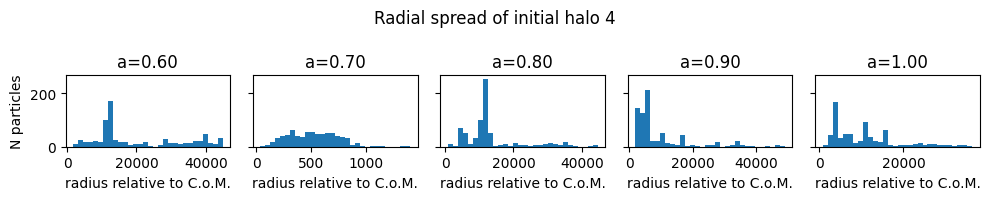

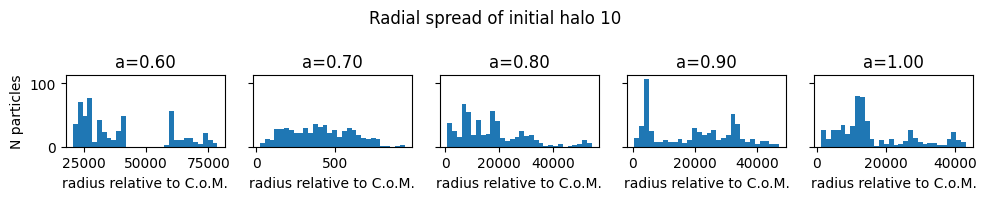

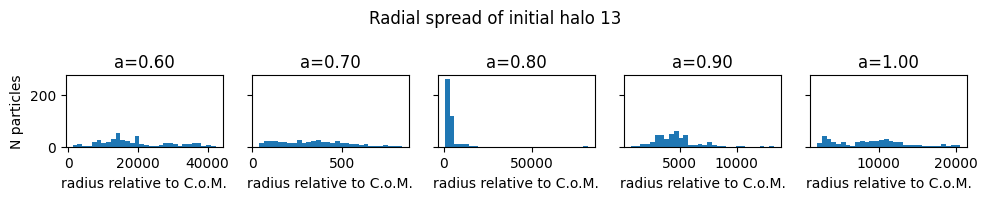

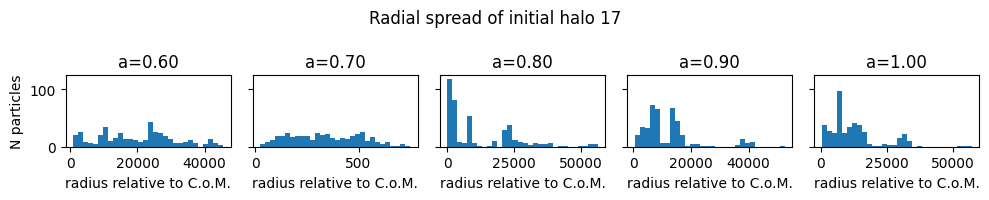

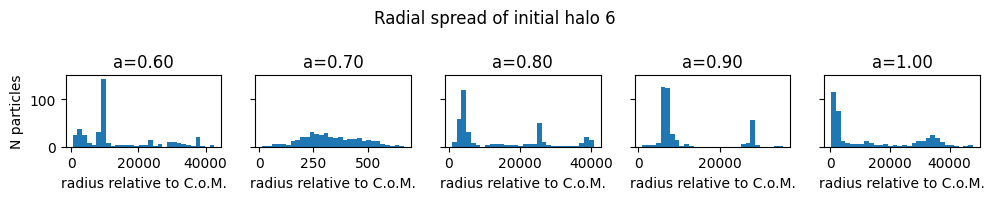

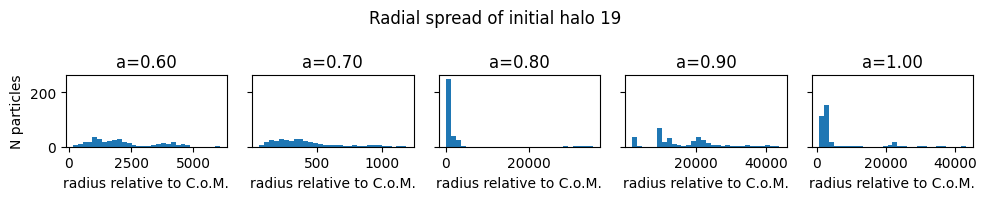

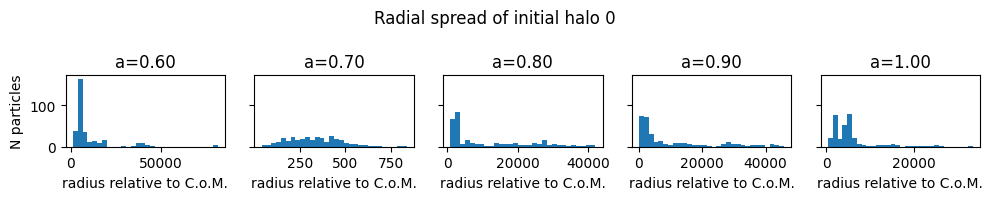

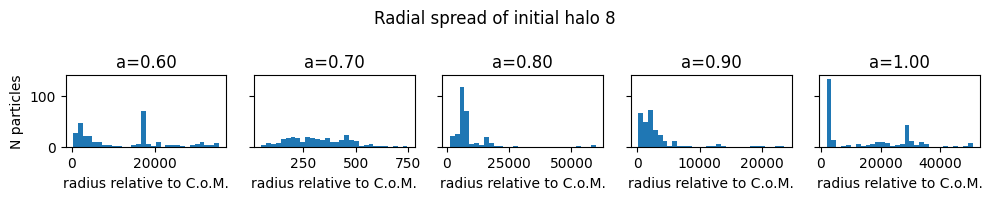

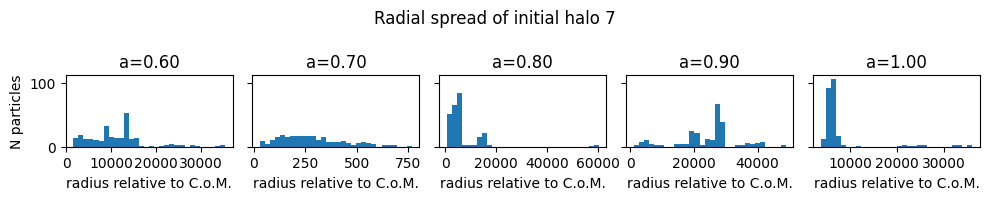

In [31]:
def plot_particle_spread(tracked_entry):
    history = tracked_entry["history"]
    halo_id = tracked_entry["halo_id"]

    fig, axes = plt.subplots(1, len(history), figsize=(2*len(history), 2), sharey=True)

    for i, h in enumerate(sorted(history, key=lambda x: x["a"])):
        a = h["a"]
        snap_dm = snapshot_dm_by_a[a]
        pids0 = tracked_entry["particle_ids"]

        id_to_index = snap_dm["id_to_index"]
        pos_all = snap_dm["pos"]
        indices = [id_to_index[pid] for pid in pids0 if pid in id_to_index]
        if len(indices) == 0:
            continue
        pos = pos_all[indices]
        com = pos.mean(axis=0)
        r = np.linalg.norm(pos - com, axis=1)

        ax = axes[i]
        ax.hist(r, bins=30)
        ax.set_title(f"a={a:.2f}")
        ax.set_xlabel("radius relative to C.o.M.")
        if i == 0:
            ax.set_ylabel("N particles")

    fig.suptitle(f"Radial spread of initial halo {halo_id}")
    plt.tight_layout()
    plt.show()

for hid in top_halo_ids_start:
    plot_particle_spread(tracked_halos[hid])


In [34]:
def summarize_host_distribution(tracked_entry):
    print(f"Initial halo: {tracked_entry['halo_id']}, N0={tracked_entry['N0']}")
    for h in sorted(tracked_entry["history"], key=lambda x: x["a"]):
        a = h["a"]
        counts = h["halo_counts"]
        total = sum(counts.values())
        print(f"\na={a:.2f}:")
        print(f"  frac_in_any_halo = {h['frac_in_any_halo']:.3f}, frac_unbound = {h['frac_unbound']:.3f}")
        # show top few host halos
        for host, c in counts.most_common(5):
            frac = c / total if total > 0 else 0
            print(f"    host={host} count={c} frac={frac:.3f}")


for hid in top_halo_ids_start:
    summarize_host_distribution(tracked_halos[hid])


Initial halo: 5, N0=1228

a=0.60:
  frac_in_any_halo = 0.102, frac_unbound = 0.898
    host=None count=1103 frac=0.898
    host=0 count=125 frac=0.102

a=0.70:
  frac_in_any_halo = 1.000, frac_unbound = 0.000
    host=5 count=1228 frac=1.000

a=0.80:
  frac_in_any_halo = 0.191, frac_unbound = 0.809
    host=None count=993 frac=0.809
    host=8 count=186 frac=0.151
    host=59 count=25 frac=0.020
    host=7 count=21 frac=0.017
    host=83 count=3 frac=0.002

a=0.90:
  frac_in_any_halo = 0.274, frac_unbound = 0.726
    host=None count=892 frac=0.726
    host=110 count=182 frac=0.148
    host=171 count=57 frac=0.046
    host=49 count=46 frac=0.037
    host=48 count=34 frac=0.028

a=1.00:
  frac_in_any_halo = 0.225, frac_unbound = 0.775
    host=None count=952 frac=0.775
    host=166 count=226 frac=0.184
    host=21 count=35 frac=0.029
    host=644 count=9 frac=0.007
    host=337 count=6 frac=0.005
Initial halo: 4, N0=730

a=0.60:
  frac_in_any_halo = 0.000, frac_unbound = 1.000
    host=N

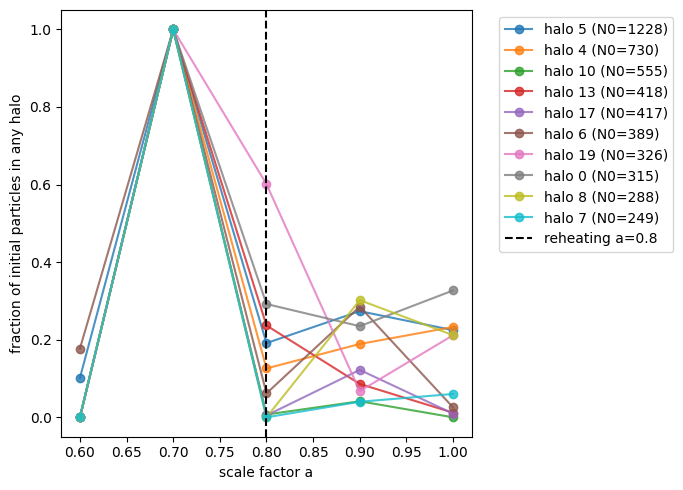

In [36]:
def history_to_df(tracked_entry):
    rows = []
    for h in tracked_entry["history"]:
        rows.append(
            {
                "a": h["a"],
                "frac_in_any_halo": h["frac_in_any_halo"],
                "frac_unbound": h["frac_unbound"],
                "r_rms": h["r_rms"],
            }
        )
    return pd.DataFrame(rows).sort_values("a")

plt.figure(figsize=(7,5))

for hid in top_halo_ids_start:
    tr = tracked_halos[hid]
    df_hist = history_to_df(tr)
    # sort by a so lines are monotonic in a
    df_hist = df_hist.sort_values("a")
    plt.plot(
        df_hist["a"],
        df_hist["frac_in_any_halo"],
        marker="o",
        label=f"halo {hid} (N0={tr['N0']})",
        alpha=0.8,
    )

# vertical line at reheating
plt.axvline(a_reheat, color="k", linestyle="--", label=f"reheating a={a_reheat}")

plt.xlabel("scale factor a")
plt.ylabel("fraction of initial particles in any halo")
plt.ylim(-0.05, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# PLOT: the total fraction of all particles bound in ANY halo through reheating
# PLOT: averages from my sample of the largest halos (out of how many total halos 
# did rockstar find right before RH?)
#

In [37]:
def get_unbound_positions_all_initial_halos(a, tracked_halos, pid2halo_by_a, snapshot_dm_by_a):
    """
    For a given scale factor a:
      - Collect all initial particles from tracked_halos
      - Select those that are *unbound* at that a (host=None or no entry)
      - Return their positions (x,y,z) as an array of shape (N_unbound, 3)
    """
    # union of all initial particle IDs (deduplicated)
    all_pids = set()
    for tr in tracked_halos.values():
        all_pids.update(tr["particle_ids"])
    all_pids = list(all_pids)

    pid2halo = pid2halo_by_a[a]
    snap_dm = snapshot_dm_by_a[a]
    id_to_index = snap_dm["id_to_index"]
    pos_all = snap_dm["pos"]

    unbound_indices = []
    for pid in all_pids:
        # unbound if no mapping or mapping is None
        host = pid2halo.get(pid, None)
        if host is None:
            if pid in id_to_index:
                unbound_indices.append(id_to_index[pid])

    if len(unbound_indices) == 0:
        return np.zeros((0, 3))

    unbound_indices = np.array(unbound_indices, dtype=int)
    return pos_all[unbound_indices]


halo 5, a=0.8: N_unbound=993
halo 5, a=0.9: N_unbound=892
halo 5, a=1.0: N_unbound=952


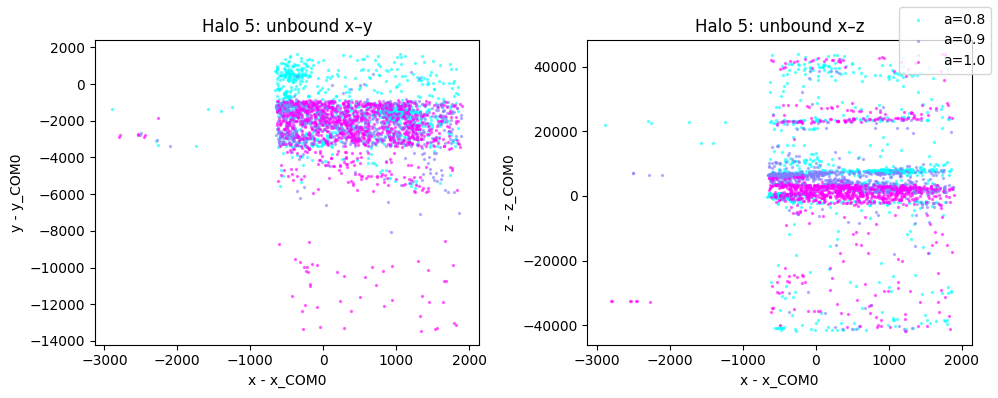

halo 4, a=0.8: N_unbound=638
halo 4, a=0.9: N_unbound=592
halo 4, a=1.0: N_unbound=560


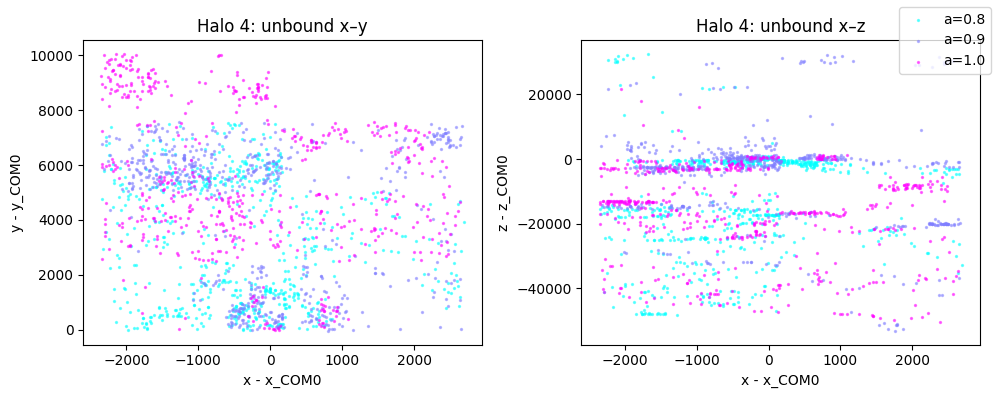

halo 10, a=0.8: N_unbound=551
halo 10, a=0.9: N_unbound=532
halo 10, a=1.0: N_unbound=555


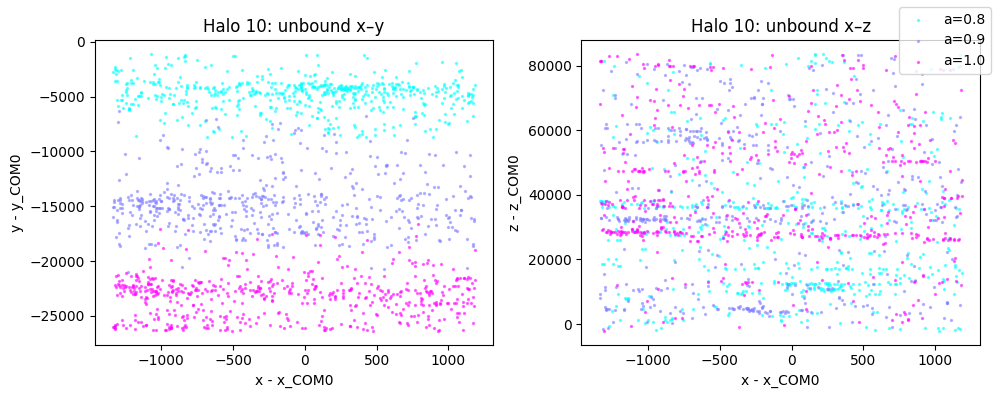

halo 13, a=0.8: N_unbound=319
halo 13, a=0.9: N_unbound=382
halo 13, a=1.0: N_unbound=413


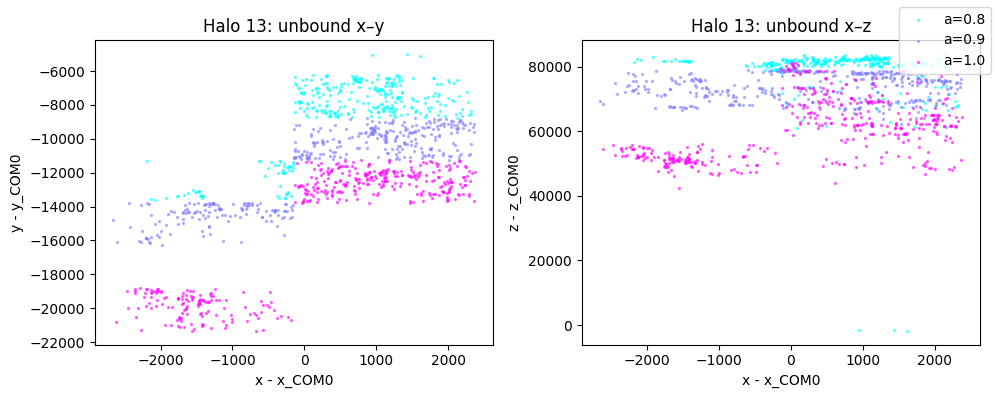

halo 17, a=0.8: N_unbound=415
halo 17, a=0.9: N_unbound=366
halo 17, a=1.0: N_unbound=413


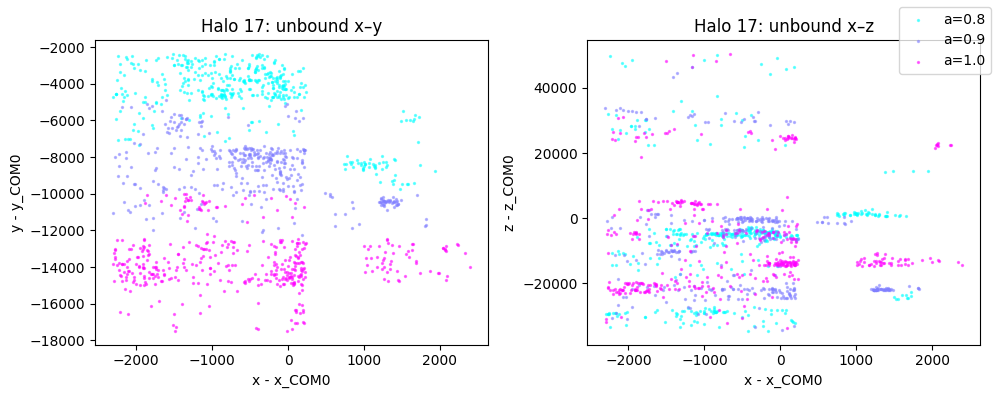

halo 6, a=0.8: N_unbound=365
halo 6, a=0.9: N_unbound=278
halo 6, a=1.0: N_unbound=379


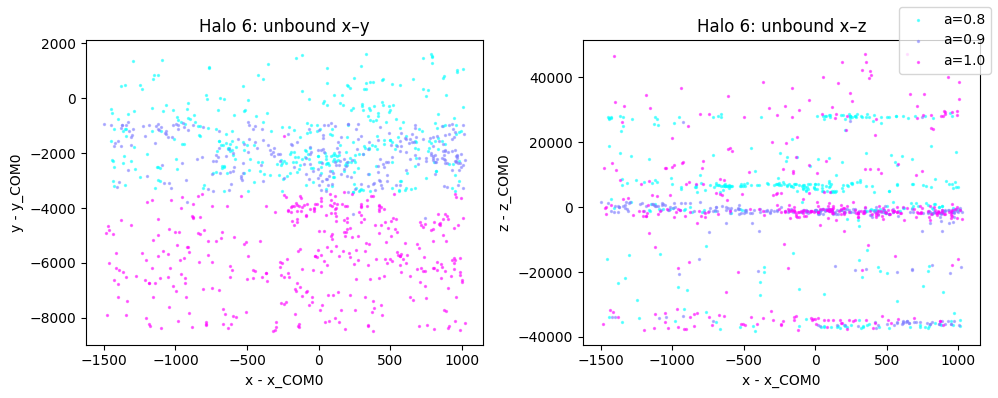

halo 19, a=0.8: N_unbound=130
halo 19, a=0.9: N_unbound=304
halo 19, a=1.0: N_unbound=257


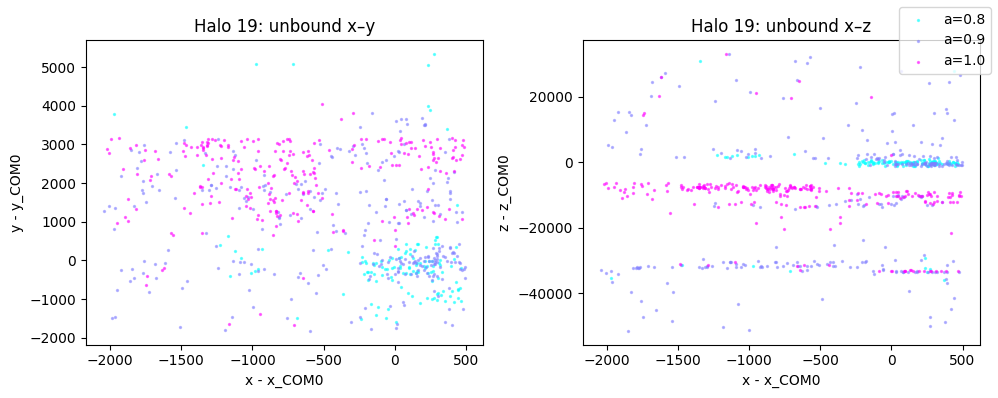

halo 0, a=0.8: N_unbound=223
halo 0, a=0.9: N_unbound=241
halo 0, a=1.0: N_unbound=212


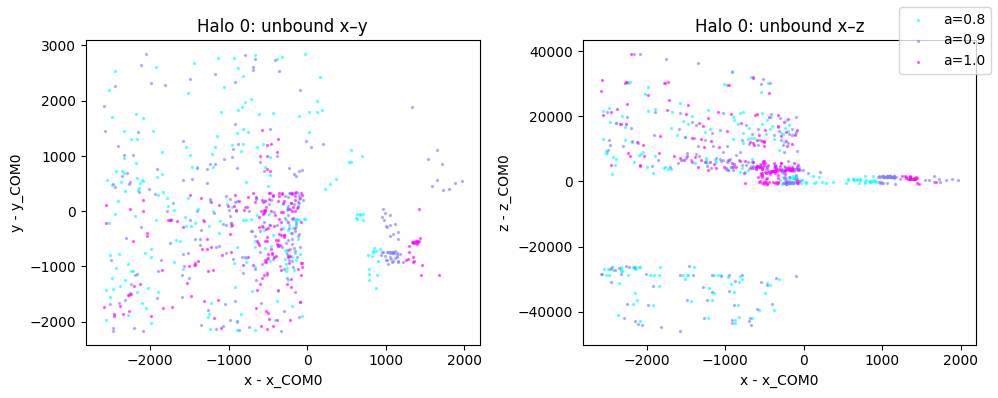

halo 8, a=0.8: N_unbound=288
halo 8, a=0.9: N_unbound=201
halo 8, a=1.0: N_unbound=227


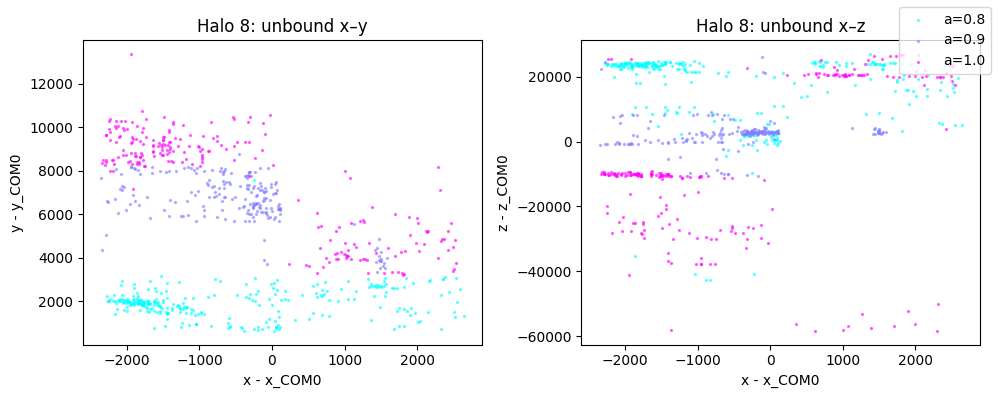

halo 7, a=0.8: N_unbound=249
halo 7, a=0.9: N_unbound=239
halo 7, a=1.0: N_unbound=234


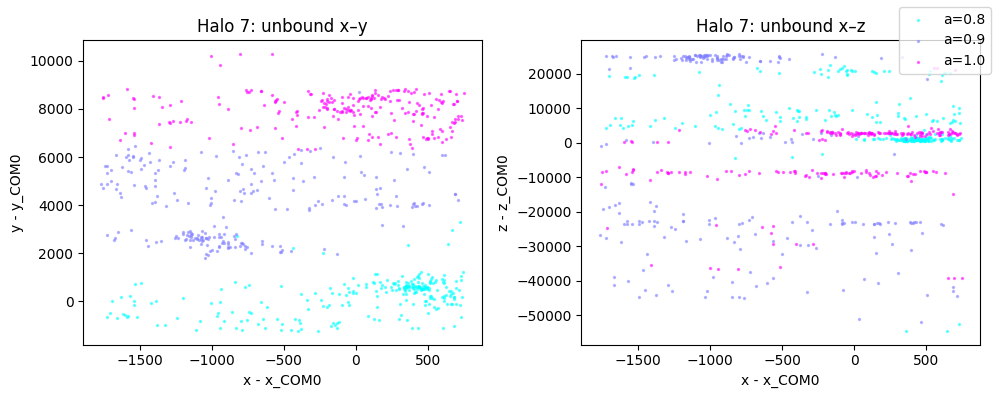

In [47]:
def plot_unbound_evolution_for_halo(
    halo_id,
    a_values,
    a_start,
    tracked_halos,
    pid2halo_by_a,
    snapshot_dm_by_a,
    COM_per_halo,
    max_points_per_snapshot=3000,
):
    """
    One figure per halo.
    For each 'a' in a_values, plot the unbound particles of that initial halo,
    centered on its COM at a_start, overlaid in different colors.

    Two subplots:
      - left: x–y
      - right: x–z
    """
    com0 = COM_per_halo[halo_id]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax_xy, ax_xz = axes

    colors = plt.cm.cool(np.linspace(0, 1, len(a_values)))  # colormap for different a

    for a, color in zip(a_values, colors):
        pos_unbound = get_unbound_positions_for_halo(
            a, halo_id, tracked_halos, pid2halo_by_a, snapshot_dm_by_a
        )
        N = len(pos_unbound)
        print(f"halo {halo_id}, a={a}: N_unbound={N}")

        if N == 0:
            continue

        # subsample if needed
        if N > max_points_per_snapshot:
            idx = np.random.choice(N, size=max_points_per_snapshot, replace=False)
            pos_plot = pos_unbound[idx]
        else:
            pos_plot = pos_unbound

        pos_centered = pos_plot - com0
        x = pos_centered[:, 0]
        y = pos_centered[:, 1]
        z = pos_centered[:, 2]

        ax_xy.scatter(x, y, s=2, alpha=0.5, label=f"a={a}", color=color)
        ax_xz.scatter(x, z, s=2, alpha=0.5, label=f"a={a}", color=color)

    ax_xy.set_xlabel("x - x_COM0")
    ax_xy.set_ylabel("y - y_COM0")
    ax_xy.set_title(f"Halo {halo_id}: unbound x–y")

    ax_xz.set_xlabel("x - x_COM0")
    ax_xz.set_ylabel("z - z_COM0")
    ax_xz.set_title(f"Halo {halo_id}: unbound x–z")

    # put legend only once (same legends for both)
    handles, labels = ax_xy.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()


# Example: use all your tracked times
a_values = [0.8,0.9,1.00]

for hid in top_halo_ids_start:
    plot_unbound_evolution_for_halo(
        halo_id=hid,
        a_values=a_values,
        a_start=a_start,
        tracked_halos=tracked_halos,
        pid2halo_by_a=pid2halo_by_a,
        snapshot_dm_by_a=snapshot_dm_by_a,
        COM_per_halo=COM_per_halo,
        max_points_per_snapshot=3000,
    )




halo 5, a=0.8: N_unbound=993
halo 5, a=0.9: N_unbound=892
halo 5, a=1.0: N_unbound=952


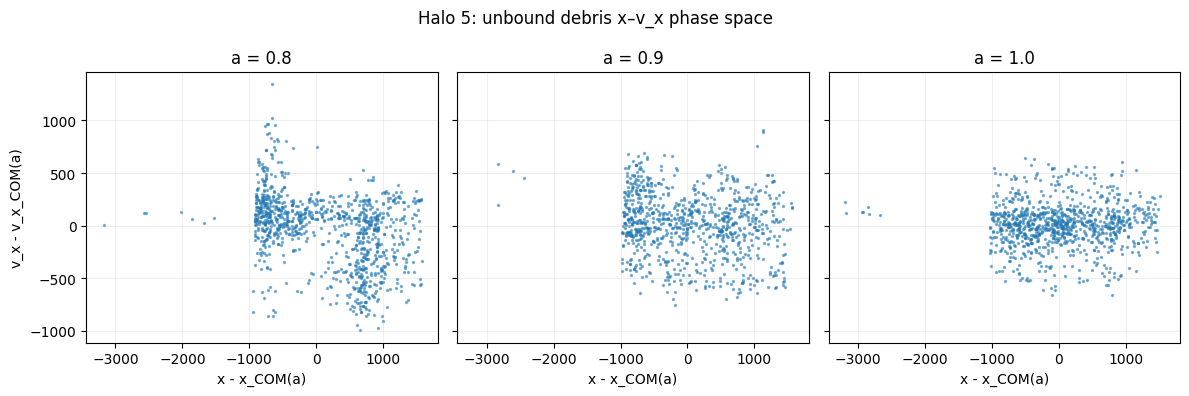

halo 4, a=0.8: N_unbound=638
halo 4, a=0.9: N_unbound=592
halo 4, a=1.0: N_unbound=560


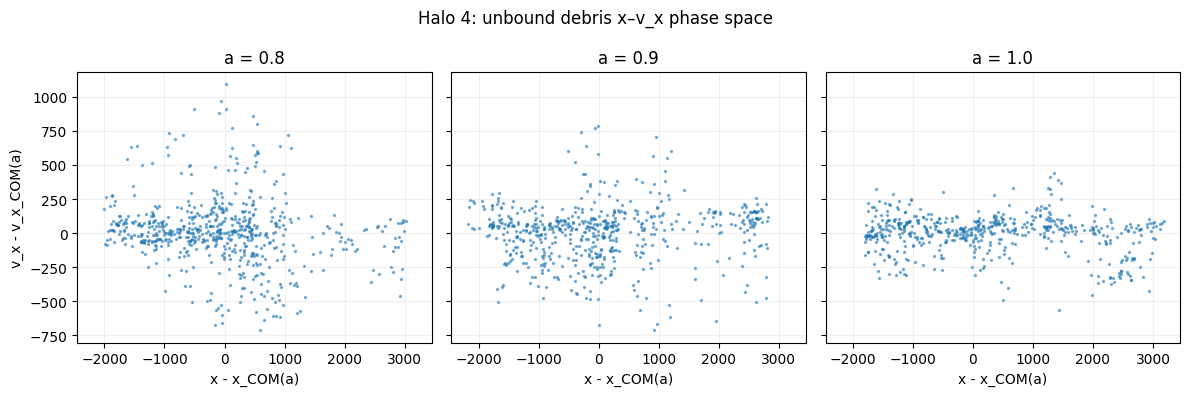

halo 10, a=0.8: N_unbound=551
halo 10, a=0.9: N_unbound=532
halo 10, a=1.0: N_unbound=555


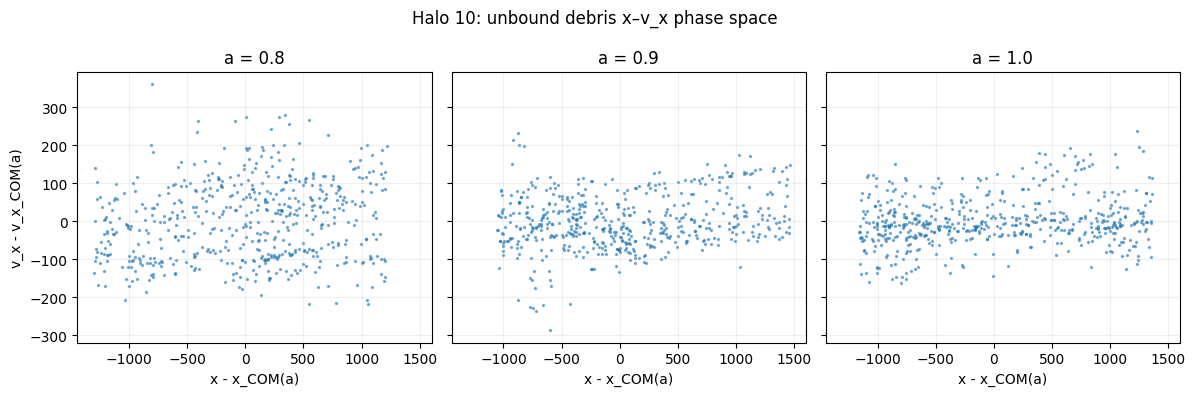

halo 13, a=0.8: N_unbound=319
halo 13, a=0.9: N_unbound=382
halo 13, a=1.0: N_unbound=413


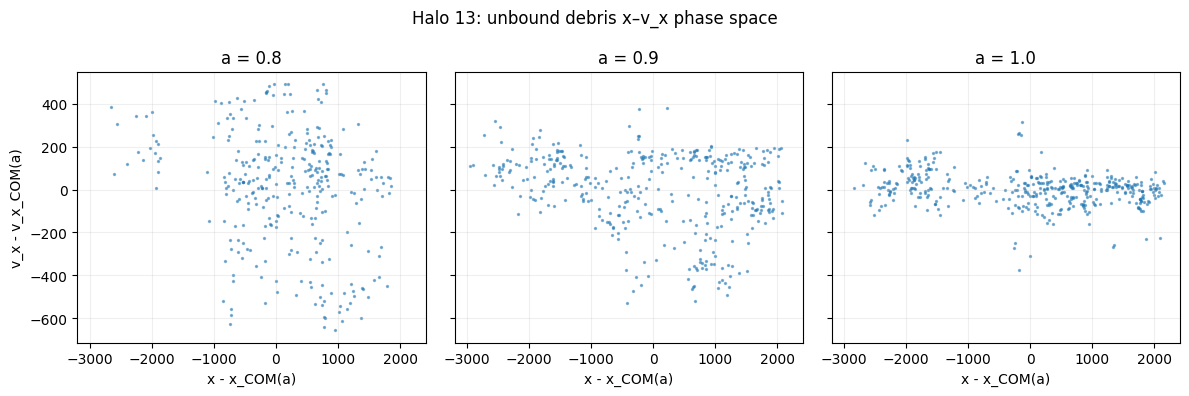

halo 17, a=0.8: N_unbound=415
halo 17, a=0.9: N_unbound=366
halo 17, a=1.0: N_unbound=413


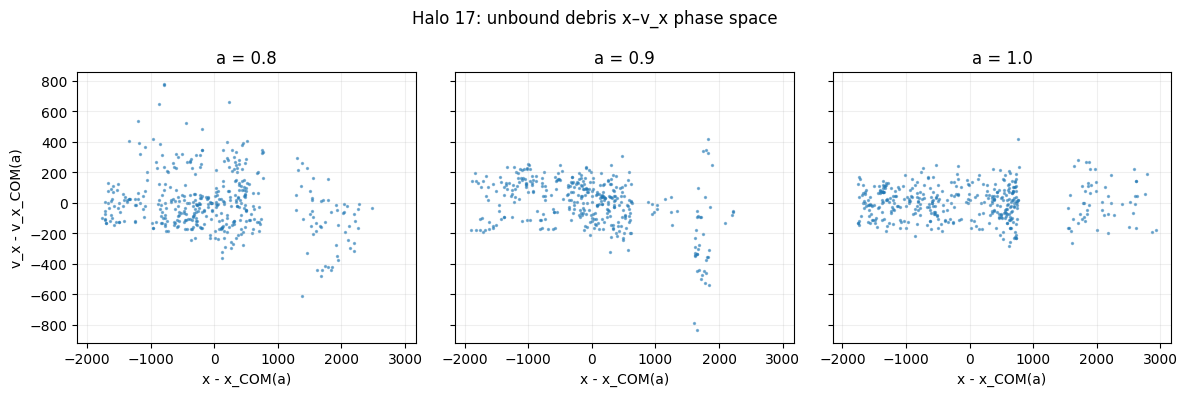

halo 6, a=0.8: N_unbound=365
halo 6, a=0.9: N_unbound=278
halo 6, a=1.0: N_unbound=379


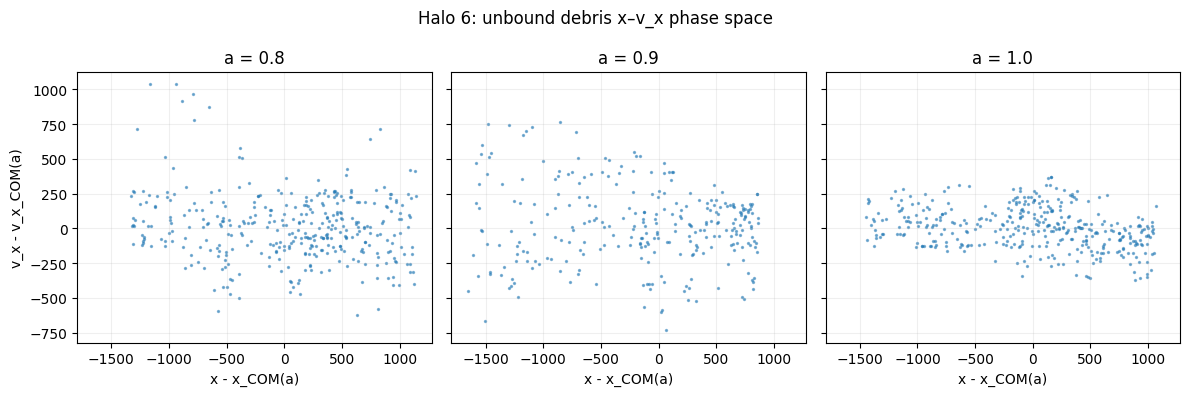

halo 19, a=0.8: N_unbound=130
halo 19, a=0.9: N_unbound=304
halo 19, a=1.0: N_unbound=257


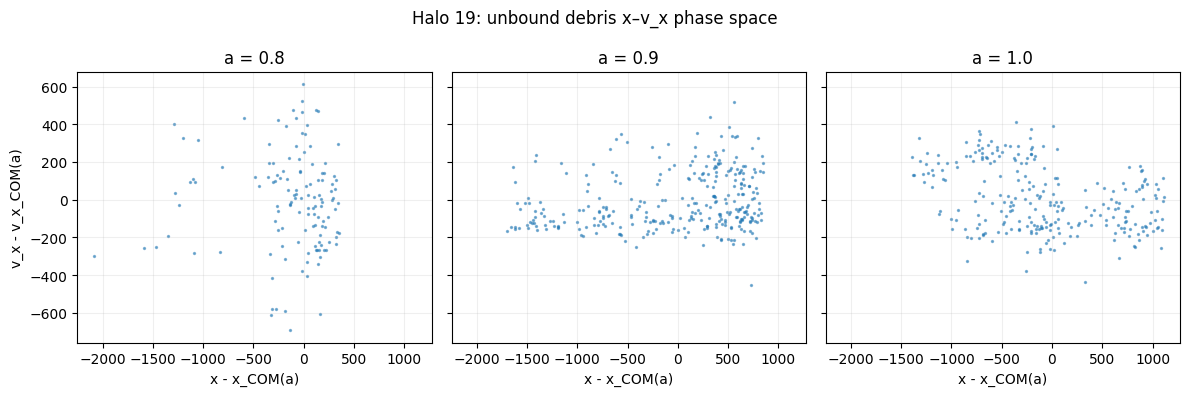

halo 0, a=0.8: N_unbound=223
halo 0, a=0.9: N_unbound=241
halo 0, a=1.0: N_unbound=212


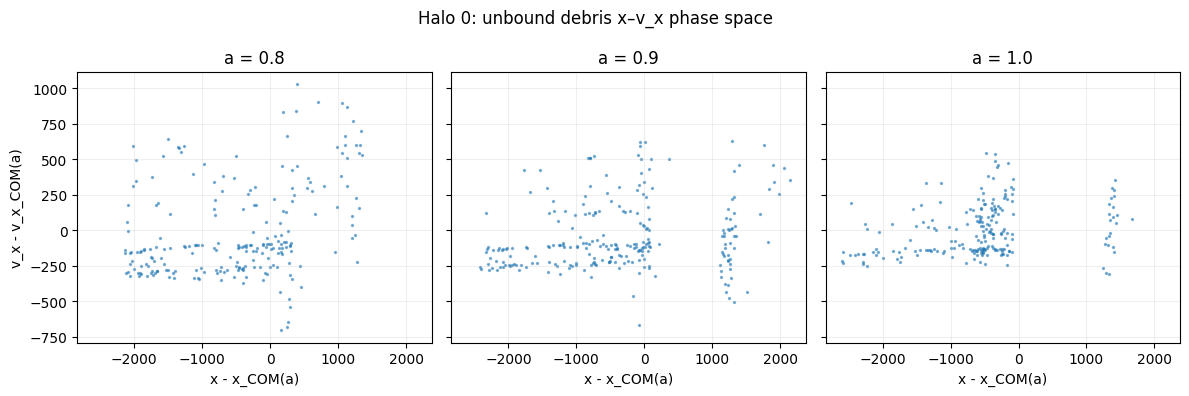

halo 8, a=0.8: N_unbound=288
halo 8, a=0.9: N_unbound=201
halo 8, a=1.0: N_unbound=227


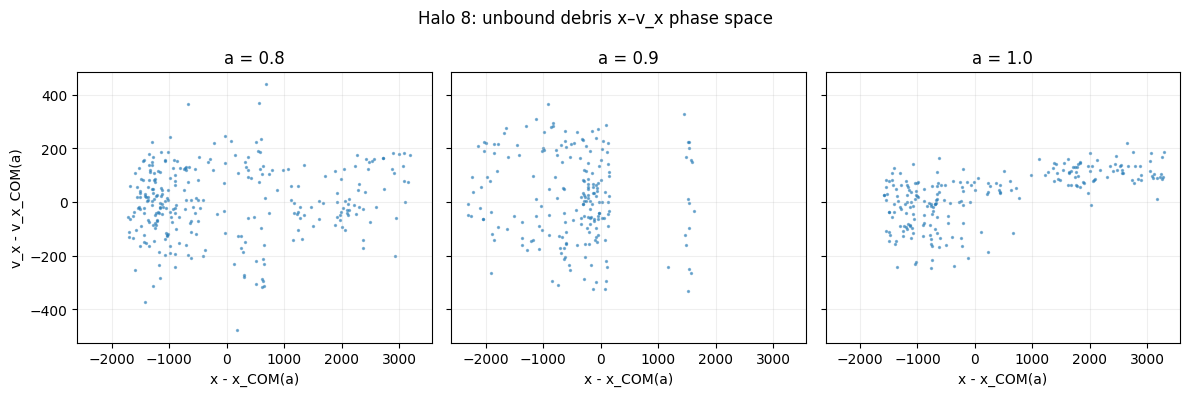

halo 7, a=0.8: N_unbound=249
halo 7, a=0.9: N_unbound=239
halo 7, a=1.0: N_unbound=234


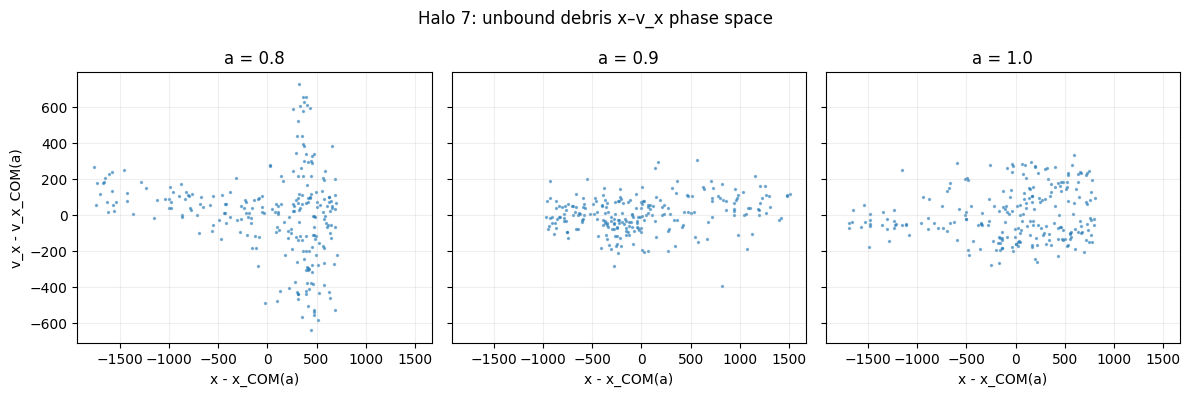

In [53]:
import numpy as np

def get_unbound_phase_space_for_halo(a, halo_id, tracked_halos, pid2halo_by_a, snapshot_dm_by_a):
    """
    For snapshot a and initial halo halo_id:
      - Take that halo's initial particle_ids
      - Select those that are unbound at a (host=None or missing in pid2halo)
      - Return (pos_unbound, vel_unbound), each shape (N_unbound, 3)
    """
    tr = tracked_halos[halo_id]
    pids0 = tr["particle_ids"]

    pid2halo = pid2halo_by_a[a]
    snap_dm = snapshot_dm_by_a[a]
    id_to_index = snap_dm["id_to_index"]
    pos_all = snap_dm["pos"]
    vel_all = snap_dm["vel"]

    indices = []
    for pid in pids0:
        host = pid2halo.get(pid, None)
        if host is None and pid in id_to_index:
            indices.append(id_to_index[pid])

    if len(indices) == 0:
        return np.zeros((0, 3)), np.zeros((0, 3))

    indices = np.array(indices, dtype=int)
    pos_unbound = pos_all[indices]
    vel_unbound = vel_all[indices]
    return pos_unbound, vel_unbound

def get_com_for_halo_at_a(a, halo_id, tracked_halos, snapshot_dm_by_a):
    """
    Compute COM position and velocity of *all* initial particles of halo_id
    at snapshot a (bound + unbound).
    Returns (pos_com, vel_com) each shape (3,)
    """
    tr = tracked_halos[halo_id]
    pids0 = tr["particle_ids"]

    snap_dm = snapshot_dm_by_a[a]
    id_to_index = snap_dm["id_to_index"]
    pos_all = snap_dm["pos"]
    vel_all = snap_dm["vel"]

    indices = [id_to_index[pid] for pid in pids0 if pid in id_to_index]
    if len(indices) == 0:
        return np.array([np.nan, np.nan, np.nan]), np.array([np.nan, np.nan, np.nan])

    indices = np.array(indices, dtype=int)
    pos = pos_all[indices]
    vel = vel_all[indices]

    pos_com = pos.mean(axis=0)
    vel_com = vel.mean(axis=0)
    return pos_com, vel_com


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def plot_unbound_phase_space_grid_for_halo(
    halo_id,
    a_values,
    tracked_halos,
    pid2halo_by_a,
    snapshot_dm_by_a,
    axis=0,                   # 0 for x–vx, 1 for y–vy, 2 for z–vz
    max_points_per_snapshot=3000,
):
    """
    One figure per halo.
    Each column = one snapshot (scale factor in a_values).
    Rows = 1, columns = len(a_values).
    All panels share the same x and y limits.

    For each a:
      - take unbound particles from this halo's initial set
      - compute COM pos/vel of *all* initial particles at that a
      - plot (x_rel, v_rel) where both are measured relative to COM
    """
    coord_label = ["x", "y", "z"][axis]

    n = len(a_values)
    fig, axes = plt.subplots(
        1, n,
        figsize=(4 * n, 4),
        sharex=True,
        sharey=True,
        squeeze=False
    )
    axes = axes[0]

    # collect all data first so sharex/sharey scaling works nicely
    all_x_rel = []
    all_v_rel = []

    per_panel_data = []

    for a in a_values:
        pos_unbound, vel_unbound = get_unbound_phase_space_for_halo(
            a, halo_id, tracked_halos, pid2halo_by_a, snapshot_dm_by_a
        )
        N = len(pos_unbound)
        print(f"halo {halo_id}, a={a}: N_unbound={N}")

        if N == 0:
            per_panel_data.append((a, None, None))
            continue

        pos_com, vel_com = get_com_for_halo_at_a(
            a, halo_id, tracked_halos, snapshot_dm_by_a
        )

        if N > max_points_per_snapshot:
            idx = np.random.choice(N, size=max_points_per_snapshot, replace=False)
            pos_use = pos_unbound[idx]
            vel_use = vel_unbound[idx]
        else:
            pos_use = pos_unbound
            vel_use = vel_unbound

        x_rel = pos_use[:, axis] - pos_com[axis]
        v_rel = vel_use[:, axis] - vel_com[axis]

        all_x_rel.append(x_rel)
        all_v_rel.append(v_rel)
        per_panel_data.append((a, x_rel, v_rel))

    # determine global limits if you want them fixed (optional)
    if all_x_rel and all_v_rel:
        x_all = np.concatenate(all_x_rel)
        v_all = np.concatenate(all_v_rel)
        x_min, x_max = np.min(x_all), np.max(x_all)
        v_min, v_max = np.min(v_all), np.max(v_all)
        # add a small margin
        dx = 0.05 * (x_max - x_min) if x_max > x_min else 1.0
        dv = 0.05 * (v_max - v_min) if v_max > v_min else 1.0
        x_lim = (x_min - dx, x_max + dx)
        v_lim = (v_min - dv, v_max + dv)
    else:
        x_lim = None
        v_lim = None

    # now actually plot per panel
    for ax, (a, x_rel, v_rel) in zip(axes, per_panel_data):
        if x_rel is None:
            ax.text(0.5, 0.5, "no unbound\nparticles", ha="center", va="center")
        else:
            ax.scatter(x_rel, v_rel, s=2, alpha=0.5)
        ax.set_title(f"a = {a}")
        ax.set_xlabel(f"{coord_label} - {coord_label}_COM(a)")
        ax.grid(alpha=0.2)

    # set labels and limits on the first axis
    axes[0].set_ylabel(f"v_{coord_label} - v_{coord_label}_COM(a)")
    if x_lim is not None:
        for ax in axes:
            ax.set_xlim(*x_lim)
            ax.set_ylim(*v_lim)

    fig.suptitle(
        f"Halo {halo_id}: unbound debris {coord_label}–v_{coord_label} phase space",
        y=0.98
    )
    plt.tight_layout()
    plt.show()

a_values = [0.8,0.9,1.00]

for hid in top_halo_ids_start:
    plot_unbound_phase_space_grid_for_halo(
    halo_id=hid,
    a_values=a_values,
    tracked_halos=tracked_halos,
    pid2halo_by_a=pid2halo_by_a,
    snapshot_dm_by_a=snapshot_dm_by_a,
    axis=0,                   # x–vx; use 1 for y–vy, 2 for z–vz
    max_points_per_snapshot=3000,
)


In [69]:
# VELOCITY DISPERSIONS!
def compute_velocity_dispersion_evolution_for_halo(
    halo_id,
    a_values,
    tracked_halos,
    pid2halo_by_a,
    snapshot_dm_by_a,
):
    """
    For each scale factor in a_values, compute velocity dispersion of the *unbound*
    debris of initial halo 'halo_id'.

    Returns a DataFrame with columns:
      a, N_unbound, sigma_x, sigma_y, sigma_z, sigma_1d
    where sigma_1d = sqrt[(sigma_x^2 + sigma_y^2 + sigma_z^2) / 3].
    """
    rows = []

    for a in a_values:
        pos_unbound, vel_unbound = get_unbound_phase_space_for_halo(
            a, halo_id, tracked_halos, pid2halo_by_a, snapshot_dm_by_a
        )
        N = len(vel_unbound)
        if N < 2:
            # not enough particles to define a dispersion
            rows.append({
                "a": a,
                "N_unbound": N,
                "sigma_x": np.nan,
                "sigma_y": np.nan,
                "sigma_z": np.nan,
                "sigma_1d": np.nan,
            })
            continue

        # COM velocity of the *unbound debris* at this snapshot
        v_com = vel_unbound.mean(axis=0)  # shape (3,)

        v_rel = vel_unbound - v_com  # (N,3)

        # per-axis dispersions (1D std dev)
        sigma_x = v_rel[:, 0].std(ddof=1)
        sigma_y = v_rel[:, 1].std(ddof=1)
        sigma_z = v_rel[:, 2].std(ddof=1)

        sigma_1d = np.sqrt((sigma_x**2 + sigma_y**2 + sigma_z**2) / 3.0)

        rows.append({
            "a": a,
            "N_unbound": N,
            "sigma_x": sigma_x,
            "sigma_y": sigma_y,
            "sigma_z": sigma_z,
            "sigma_1d": sigma_1d,
        })

    df = pd.DataFrame(rows).sort_values("a")
    return df

def fit_sigma_power_law(df_sig, col="sigma_1d"):
    """
    Fit sigma(col) ~ a^n using log-log linear regression.
    Returns (n, log_sigma0), where
      sigma(a) ~ exp(log_sigma0) * a^n
    """
    mask = np.isfinite(df_sig[col]) & np.isfinite(df_sig["a"]) & (df_sig[col] > 0)
    if mask.sum() < 2:
        return np.nan, np.nan

    a = df_sig.loc[mask, "a"].values
    sigma = df_sig.loc[mask, col].values

    log_a = np.log(a)
    log_sigma = np.log(sigma)

    n, log_sigma0 = np.polyfit(log_a, log_sigma, 1)
    return n, log_sigma0

import matplotlib.pyplot as plt

def plot_sigma_evolution_for_halo(df_sig, halo_id, free_stream_ref=True):
    """
    Plot sigma_1d(a) with an optional 1/a reference and power-law best fit.
    """
    mask = np.isfinite(df_sig["sigma_1d"]) & (df_sig["sigma_1d"] > 0)
    a = df_sig.loc[mask, "a"].values
    sigma = df_sig.loc[mask, "sigma_1d"].values

    plt.figure(figsize=(6,4))
    plt.loglog(a, sigma, "o-", label="σ_1D ")

    # Power-law fit
    n_fit, log_sigma0 = fit_sigma_power_law(df_sig, col="sigma_1d")
    if np.isfinite(n_fit):
        a_fit = np.linspace(a.min(), a.max(), 100)
        sigma_fit = np.exp(log_sigma0) * a_fit**n_fit
        plt.loglog(a_fit, sigma_fit, "--", label=f"fit: σ ∝ a^{n_fit:.2f}")

    plt.xlabel("scale factor a")
    plt.ylabel("σ (km/s)")
    plt.title(f"Halo {halo_id}: velocity dispersion of FORMER member particles,\nnow UNBOUND (not in any halos at all according to rockstar)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if np.isfinite(n_fit):
        print(f"Halo {halo_id}: best-fit σ_1D ∝ a^{n_fit:.2f}")
    else:
        print(f"Halo {halo_id}: not enough points to fit power law.")


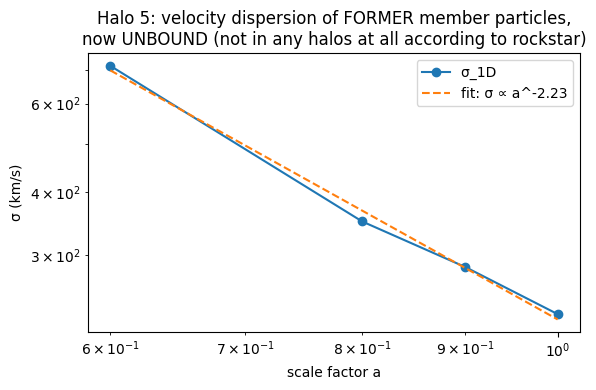

Halo 5: best-fit σ_1D ∝ a^-2.23


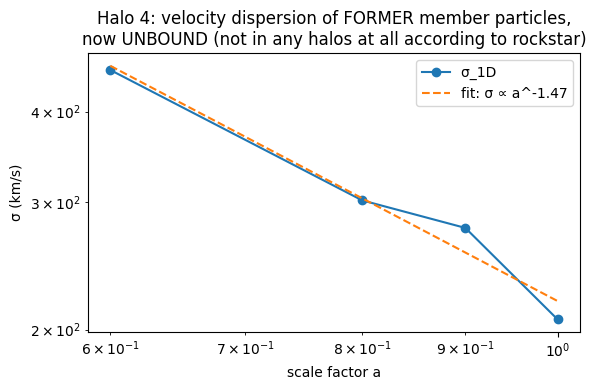

Halo 4: best-fit σ_1D ∝ a^-1.47


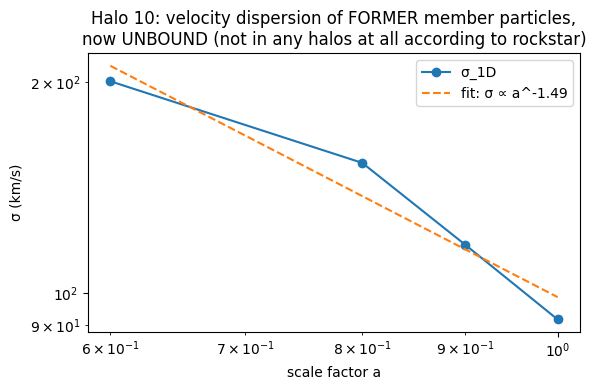

Halo 10: best-fit σ_1D ∝ a^-1.49


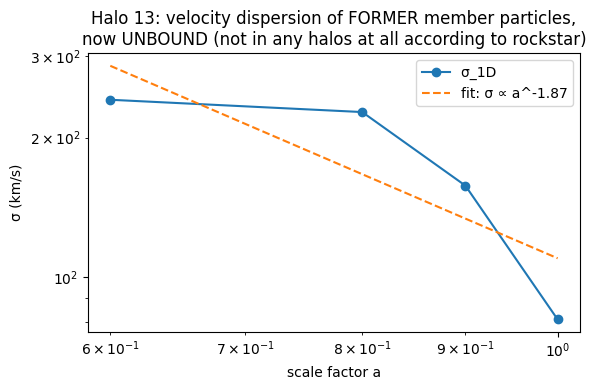

Halo 13: best-fit σ_1D ∝ a^-1.87


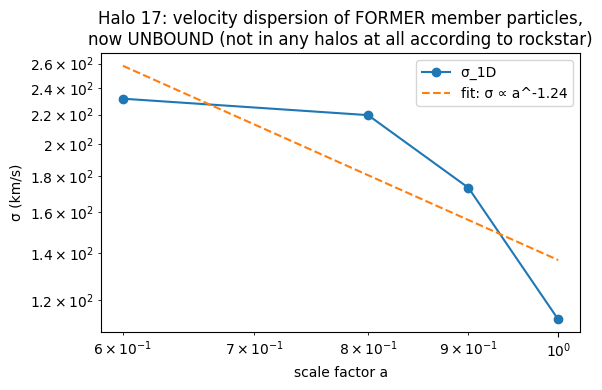

Halo 17: best-fit σ_1D ∝ a^-1.24


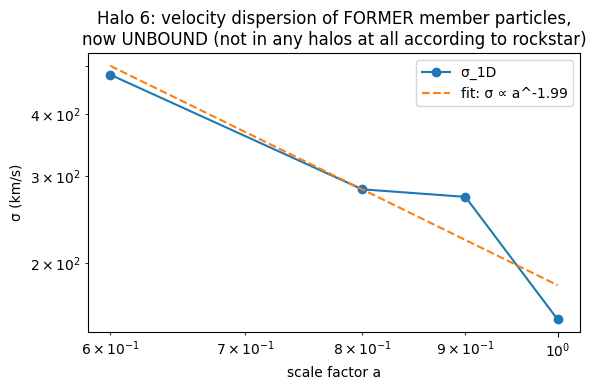

Halo 6: best-fit σ_1D ∝ a^-1.99


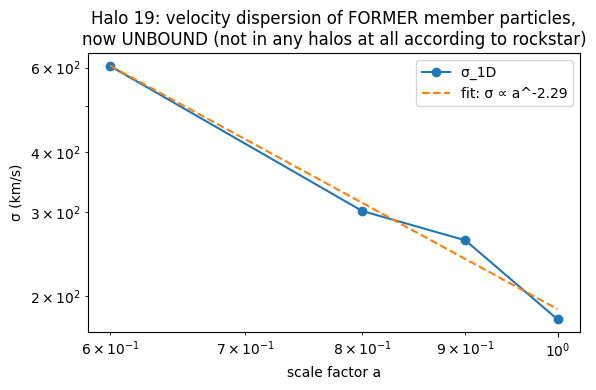

Halo 19: best-fit σ_1D ∝ a^-2.29


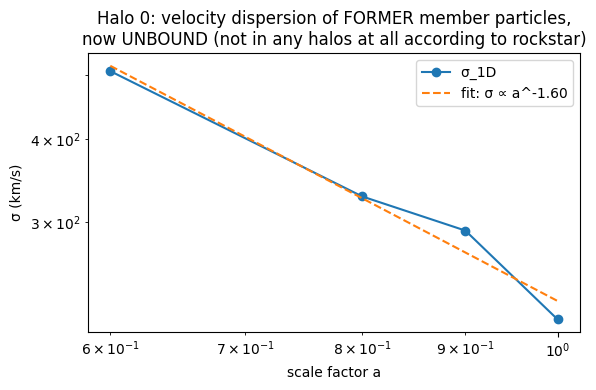

Halo 0: best-fit σ_1D ∝ a^-1.60


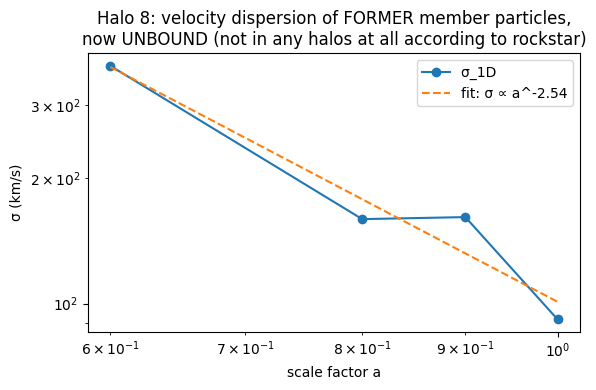

Halo 8: best-fit σ_1D ∝ a^-2.54


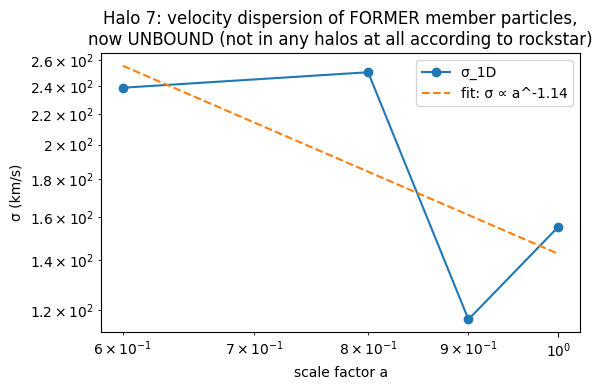

Halo 7: best-fit σ_1D ∝ a^-1.14


,halo_id,n_fit
0,5,-2.228669
1,4,-1.465545
2,10,-1.491906
3,13,-1.874949
4,17,-1.242458
5,6,-1.992211
6,19,-2.291321
7,0,-1.595822
8,8,-2.541281
9,7,-1.138717


In [70]:

sigma_evolution = {}
slopes = []

for hid in top_halo_ids_start:
    
    df_sig = compute_velocity_dispersion_evolution_for_halo(
    hid, a_list,
    tracked_halos,
    pid2halo_by_a,
    snapshot_dm_by_a,)
    plot_sigma_evolution_for_halo(df_sig, hid)

    df_sig = compute_velocity_dispersion_evolution_for_halo(
        hid, a_list,
        tracked_halos,
        pid2halo_by_a,
        snapshot_dm_by_a,
    )
    sigma_evolution[hid] = df_sig

    n_fit, _ = fit_sigma_power_law(df_sig, col="sigma_1d")
    slopes.append({"halo_id": hid, "n_fit": n_fit})

slopes_df = pd.DataFrame(slopes)
slopes_df


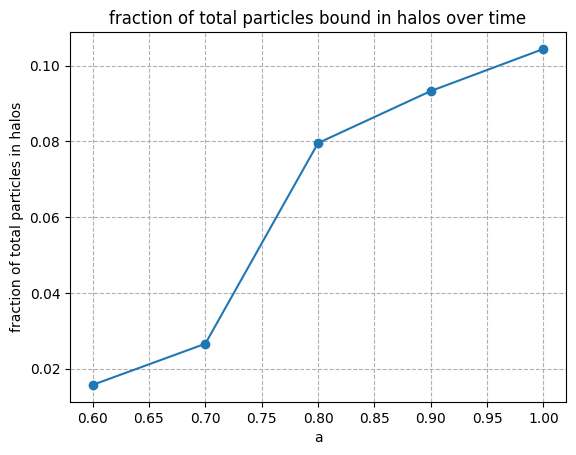

In [48]:
# total prtcles
N_total = 96.**3
fractions = []
for snap, halos in enumerate(halodict_by_a.values()):
    
    particles_in_halos = set()  #empty set
    for particle_set in halos.values(): 
        particles_in_halos = particles_in_halos.union(particle_set)
        
    frac = len(particles_in_halos)/N_total
    fractions.append(frac)
    
plt.plot(a_list, fractions, marker="o")
plt.xlabel("a")
plt.ylabel("fraction of total particles in halos")
plt.title("fraction of total particles bound in halos over time")
plt.grid(True, linestyle="--")
plt.show()

In [71]:
# lastly for now: assessing sphericity & isolation

import numpy as np
import pandas as pd

def compute_shape_from_positions(pos):
    """
    pos: (N, 3) array of particle positions (Mpc/h, comoving).
    Returns (b_to_a, c_to_a, sphericity) using the reduced inertia tensor.
    """
    if pos.shape[0] < 3:
        return np.nan, np.nan, np.nan

    # center on COM
    x = pos - pos.mean(axis=0)

    r2 = np.sum(x**2, axis=1)
    mask = r2 > 0
    x = x[mask]
    r2 = r2[mask]
    if x.shape[0] < 3:
        return np.nan, np.nan, np.nan

    # reduced inertia tensor: I_ij = Σ (x_i x_j / r^2)
    w = 1.0 / r2
    I = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            I[i, j] = np.sum(w * x[:, i] * x[:, j])

    # eigenvalues
    evals, evecs = np.linalg.eigh(I)
    # sort descending
    evals = np.sort(evals)[::-1]
    a2, b2, c2 = evals  # a2 >= b2 >= c2

    if a2 <= 0 or b2 <= 0 or c2 <= 0:
        return np.nan, np.nan, np.nan

    b_to_a = np.sqrt(b2 / a2)
    c_to_a = np.sqrt(c2 / a2)
    sphericity = c_to_a  # standard convention: s = c/a

    return b_to_a, c_to_a, sphericity


def compute_shapes_for_all_halos_at_a(
    a,
    df_by_a,
    halodict_by_a,
    snapshot_dm_by_a,
    min_particles=50,
):
    """
    For snapshot 'a', compute b/a, c/a, sphericity for each halo with >= min_particles.
    Returns a DataFrame with one row per halo.
    """
    df = df_by_a[a].copy()
    halodict = halodict_by_a[a]
    snap_dm = snapshot_dm_by_a[a]
    id_to_index = snap_dm["id_to_index"]
    pos_all = snap_dm["pos"]

    rows = []

    for _, row in df.iterrows():
        hid = int(row["id"])
        pids = halodict.get(hid, None)
        if pids is None:
            continue
        pids = np.array(pids, dtype=int)
        if pids.size < min_particles:
            continue

        idx = [id_to_index[pid] for pid in pids if pid in id_to_index]
        if len(idx) < min_particles:
            continue

        pos = pos_all[idx]
        b_to_a, c_to_a, sphericity = compute_shape_from_positions(pos)

        rows.append({
            "id": hid,
            "Np": len(idx),
            "b_to_a": b_to_a,
            "c_to_a": c_to_a,
            "sphericity": sphericity,
            # include some halo properties from catalog if present:
            "mvir": row.get("mvir", np.nan),
            "rvir": row.get("rvir", np.nan),
            "x": row.get("x", np.nan),
            "y": row.get("y", np.nan),
            "z": row.get("z", np.nan),
        })

    return pd.DataFrame(rows).sort_values("Np", ascending=False)

# Example for your pre-reheating snapshot:
shape_df = compute_shapes_for_all_halos_at_a(
    a_start,
    df_by_a=df_by_a,
    halodict_by_a=halodict_by_a,
    snapshot_dm_by_a=snapshot_dm_by_a,
    min_particles=50,   # tweak threshold if needed
)
shape_df.head()


def compute_isolation(
    shape_df,
    box_size=None,
    use_periodic=False,
):
    """
    Given shape_df with columns ['id','x','y','z','rvir'], compute
    isolation = D_min / rvir for each halo, where D_min is distance to nearest neighbor.

    If box_size is provided and use_periodic=True, uses periodic distances.
    """
    positions = shape_df[["x", "y", "z"]].values
    rvir = shape_df["rvir"].values
    ids = shape_df["id"].values
    N = len(shape_df)

    isolation_vals = np.full(N, np.nan)

    for i in range(N):
        dx = positions - positions[i]

        if box_size is not None and use_periodic:
            dx = np.abs(dx)
            dx = np.minimum(dx, box_size - dx)

        dist = np.sqrt(np.sum(dx**2, axis=1))
        dist[i] = np.inf  # ignore self
        dmin = np.min(dist)

        if rvir[i] > 0:
            isolation_vals[i] = dmin / rvir[i]
        else:
            isolation_vals[i] = np.nan

    shape_df = shape_df.copy()
    shape_df["isolation"] = isolation_vals
    return shape_df

BOX_SIZE = 128

shape_iso_df = compute_isolation(
    shape_df,
    box_size=BOX_SIZE,
    use_periodic=True,
)
shape_iso_df.head()



,id,Np,b_to_a,c_to_a,sphericity,mvir,rvir,x,y,z,isolation
5,5,1228,0.894236,0.647563,0.647563,NaN,NaN,NaN,NaN,NaN,NaN
4,4,730,0.817067,0.632035,0.632035,NaN,NaN,NaN,NaN,NaN,NaN
10,10,555,0.861337,0.553532,0.553532,NaN,NaN,NaN,NaN,NaN,NaN
12,13,418,0.752602,0.657530,0.657530,NaN,NaN,NaN,NaN,NaN,NaN
16,17,417,0.871023,0.619925,0.619925,NaN,NaN,NaN,NaN,NaN,NaN


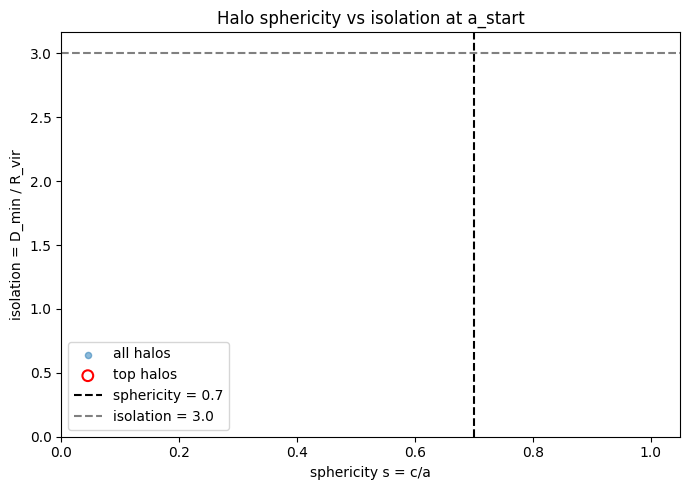

(array([ 8.,  5., 18., 27., 32., 25., 27., 13.,  6.,  3.]),
 array([0.38585942, 0.43571545, 0.48557149, 0.53542752, 0.58528355,
        0.63513959, 0.68499562, 0.73485165, 0.78470769, 0.83456372,
        0.88441975]),
 <BarContainer object of 10 artists>)

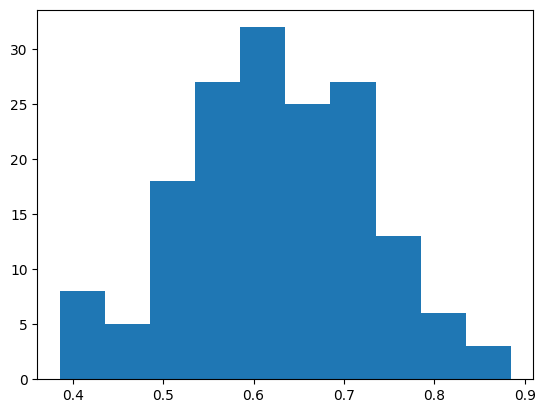

In [74]:
import matplotlib.pyplot as plt

def plot_shape_vs_isolation(
    shape_iso_df,
    s_thresh=0.7,
    iso_thresh=3.0,
    top_halo_ids=None,
):
    """
    Scatter plot: sphericity (c/a) vs isolation for all halos.
    Draw threshold lines and highlight top halos if provided.
    """
    df = shape_iso_df.copy()

    fig, ax = plt.subplots(figsize=(7,5))

    # all halos
    ax.scatter(
        df["sphericity"],
        df["isolation"],
        s=20,
        alpha=0.5,
        label="all halos",
    )

    # highlight top halos (largest at a_start)
    if top_halo_ids is not None:
        sel = df["id"].isin(top_halo_ids)
        ax.scatter(
            df.loc[sel, "sphericity"],
            df.loc[sel, "isolation"],
            s=60,
            facecolors="none",
            edgecolors="red",
            linewidths=1.5,
            label="top halos",
        )

    # threshold lines
    ax.axvline(s_thresh, color="k", linestyle="--", label=f"sphericity = {s_thresh}")
    ax.axhline(iso_thresh, color="gray", linestyle="--", label=f"isolation = {iso_thresh}")

    ax.set_xlabel("sphericity s = c/a")
    ax.set_ylabel("isolation = D_min / R_vir")
    ax.set_title("Halo sphericity vs isolation at a_start")

    ax.set_xlim(0.0, 1.05)
    ax.set_ylim(bottom=0.0)

    # de-duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    new_handles, new_labels = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            new_handles.append(h)
            new_labels.append(l)
    ax.legend(new_handles, new_labels, loc="best")

    plt.tight_layout()
    plt.show()


s_thresh = 0.7   # fairly round
iso_thresh = 3.0 # fairly isolated

plot_shape_vs_isolation(
    shape_iso_df,
    s_thresh=s_thresh,
    iso_thresh=iso_thresh,
    top_halo_ids=top_halo_ids_start,
)

plt.hist(shape_iso_df["sphericity"])